# What is the True Normal Human Body Temperature? 

### Submission by Joshua Karpen

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from statsmodels.stats.weightstats import ztest

In [3]:
#Read in data
df = pd.read_csv('data/human_body_temperature.csv')

In [5]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [35]:
np.mean(df.temperature)

98.24923076923078

In [36]:
np.std(df.temperature)

0.7303577789050377

In [37]:
len(df)

130

## 1 - Is the distribution of body temperatures normal?
I will start by checking normality graphically, with a simple histogram of temperatures and a view of the estimated cumulative density function (ECDF).

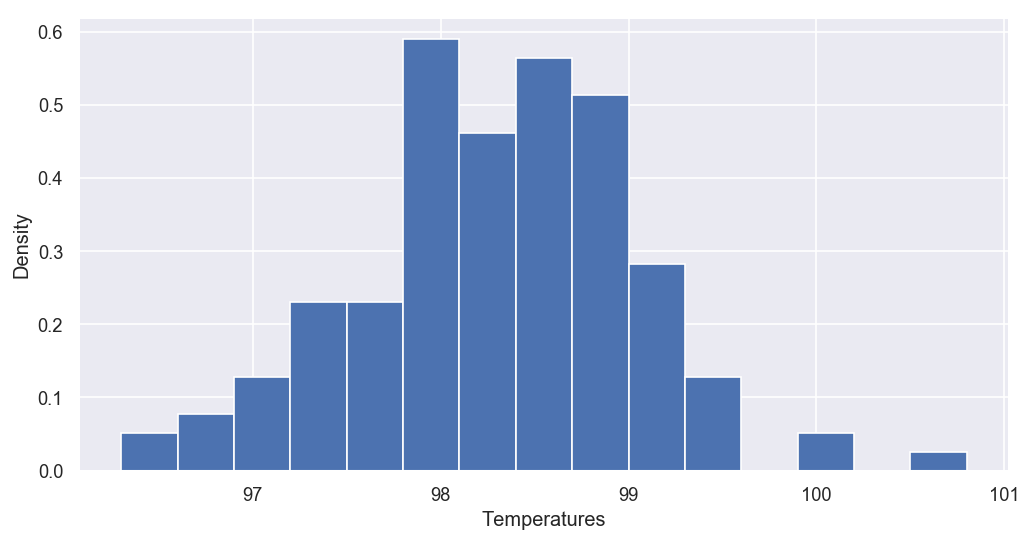

In [34]:
#Plotting a simple histogram
_ = plt.figure(figsize=(10, 5), dpi=120)
_ = plt.hist(df.temperature, bins=15, density=True)
_ = plt.xlabel('Temperatures')
_ = plt.ylabel('Density')

In [18]:
#Create function to generate ECDF, code taken from DataCamp exercises
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements"""
    n = len(data)
    
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    
    return x, y

In [21]:
#Compute summary stats
mean = np.mean(df.temperature)
std = np.std(df.temperature)
#Generate a normal distribution with same mean/standard deviation as the temperature data
samples = np.random.normal(mean, std, size=10000)

#Generating the ECDF for the actual data and the samples to compare against
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(samples)

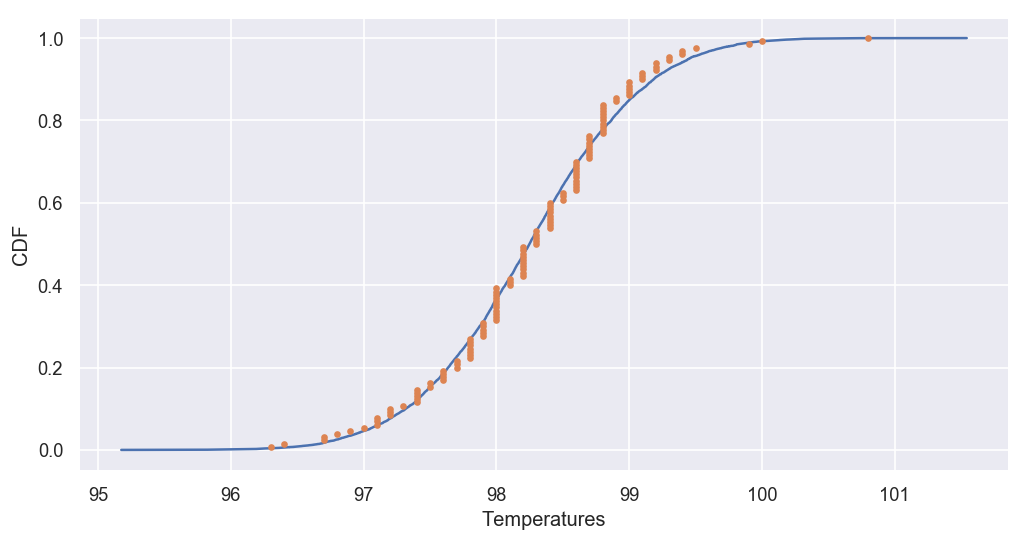

In [23]:
#Visualize ECDF of actual data against normal samples
_ = plt.figure(figsize=(10, 5), dpi=120)
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Temperatures')
_ = plt.ylabel('CDF')

The visualizations show a distribution that appears very close to normal, but may not completely follow the normal distribution. In the histogram the counts are higher below the mean of 98.24, and are more sparse at the high end of the range. 

In the ECDF the actual values (the orange dots) closely hug the normalized samples (the blue line) but are slightly low in the middle of the range, and slightly high around 99 degrees. 

To further test the normality of the temperatures I will use the Kolmogorov-Smirnov test, described here: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test. The test is available in scipy using the kstest function: https://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stats.kstest.html.

In [74]:
test_stat = kstest(df['temperature'], 'norm', args=(mean, std))
test_stat

KstestResult(statistic=0.06385348427883908, pvalue=0.6645320172840661)

The KS Test Statistic is 0.064, with a p-value 0.665. According to the kstest documentation:

"If the p-value is greater than the significance level (say 5%), then we cannot reject the hypothesis that the data come from the given distribution."

The p-value is well above the standard 5% level so I cannot reject the null hypothesis that the distribution of temperatures is normal. 

## 2 - Is the sample size large? Are the observations independent?

The sample size is 130 records, which is not large. The observations are independent, because one person's temperature is not affected from the other temperature measurements taken (each measurement is independent of the rest). 

## 3 - Is the true population mean really 98.6 degrees F?

I will check whether the true population mean is 98.6 degrees based on our sample data. First using a bootstrap hypothesis test, then with a frequentist test. For this test my null hypothesis is that the true population mean of our sample data is 98.6. 

In [70]:
#First try a bootstrap hypothesis test
#The null hypothesis is that the true population mean is 98.6 degrees F
pop_temp = 98.6

#Shift our temperature data based on the assumed population mean
temp_shifted = df.temperature - np.mean(df.temperature) + pop_temp


In [71]:
#Calculate the test statistic as the sample mean minus the assumed population mean
def diff_from_temp(data, pop_temp=98.6):
    return np.mean(data) - pop_temp

diff_obs = diff_from_temp(df.temperature)

diff_obs

-0.35076923076921673

In [62]:
#Define function to generate bootstrap replicas
#Taken from DataCamp exercises
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

#Define function to generate many bootstrap replicas
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    
    return bs_replicates

In [72]:
#Generate 10,000 bootstrap replicas by comparing the shifted temps 
#... against the assumed mean population temp
bs_replicates = draw_bs_reps(temp_shifted, diff_from_temp, 10000)

#Generate p-value as the number of bootstrap replicas where the difference is less than -0.35,
#... the difference between the sample mean and the assumed population mean.
p_value = np.sum(bs_replicates <= diff_obs) / 10000
#View the p-value
p_value

0.0

The bootstrap method reveals a p-value of 0. This is because none of the bootstrapped replicates had a difference as large or greater than the difference between our sample data and the assumed population mean of 98.6. Therefore we reject the null hypothesis 

Next I will try a frequentist test. I will use a one-sample test because I am trying to compare the sample data to a single number, not to another set of data.

I also plan to start with a t-test. According to general rule of thumb (for example https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/hypothesis-testing/t-score-vs-z-score/) it is best to use the t-score if the sample size is under 30, or if the population standard deviation is unknown. In this case the sample size is above 30 (130) but we do not know the standard deviation of human body temperature in the overall population, so a t-test is more appropriate. 

In [78]:
#Compute a one-sample t-test statistic
test_stat = stats.ttest_1samp(df['temperature'], 98.6)

test_stat

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

The p-value from this test is extremely small, which means there is a very low probability of this outcome if the null hypothesis (that the population mean is 98.6) is true. Therefore I again reject the null hypothesis. 

Per the instructions I will now try the two-sided test instead of the one-sided test. Technically I don't have another dataset to compare against, but I can use the shifted temperatures created earlier because they were designed to simulate a situation where the mean is 98.6. 

In [79]:
#Compute a two-sample t-test statistic.
test_stat = stats.ttest_ind(df['temperature'], temp_shifted)
test_stat

Ttest_indResult(statistic=-3.8571425402051243, pvalue=0.00014496313286971316)

Once again I get an extremely low p-value, therefore I can reject the null hypothesis that the true population mean is 98.6.

I will also attempt to perform a one-sample z-test against this dataset, even though the true population standard deviation is not known. I will do this using statsmodels ztest function.


In [85]:
test_stat = ztest(x1=df.temperature, value=98.6)

test_stat

(-5.4548232923645195, 4.9021570141012155e-08)

Again the p-value is extremely low, so I reject the null hypothesis that the population mean is 98.6.

## 4 - Repeat both frequentist tests with a small sample of size 10

In [86]:
temp_small = np.random.choice(df.temperature, size=10)
print(temp_small)

[98.7 98.5 98.8 98.2 98.4 97.6 98.  97.5 98.6 98.8]


In [88]:
ttest = stats.ttest_1samp(temp_small, 98.6)
ttest

Ttest_1sampResult(statistic=-1.9314266925012828, pvalue=0.08547674296642838)

In [89]:
ztest = ztest(x1=temp_small, value=98.6)
ztest

(-1.9314266925012828, 0.05343030684665296)

In this situation the t-test is definitely the correct choice, because the sample size is smaller than 30 and we still do not know the population standard deviation. 

I notice that the test statistic is the same in both cases, -1.9314, but the p-values different. The t-test p-value is 0.085, while the z-test p-value is 0.053. It seems the z-test statistic is lower and hence more likely to cause us to reject the null hypothesis. The t-test p-value is higher and is less likely to cause a rejection of the null hypothesis. So I would say the t-test is more forgiving than the z-test, possibly because it was designed for working with smaller datasets.

## 5 - What temperature is considered abnormal?

To test this I will start by computing bootstrap estimates of the confidence interval covering 99.7% of the data, which should capture values three standard deviations away from the mean.

In [99]:
def bootstrap_conf_int(data, alpha):
    bs_sample = np.random.choice(data, len(data))
    
    loc = np.mean(bs_sample)
    scale = np.std(bs_sample)
    
    conf_int = stats.norm.interval(alpha=alpha, loc=loc, scale=scale)
    
    return conf_int


In [100]:
#Calculate the confidence interval using bootstrap methods with one draw formula
bs_conf_int = bootstrap_conf_int(df.temperature, alpha=.997)

bs_conf_int

(95.84117626713532, 100.82651604055697)

From the bootstrap test it appears any temperature below 95.8 degrees or above 100.8 degrees is outside of three standard deviations and should be considered abnormal. 

Next I will try calculating using frequentist methods, which will use the same function but without calculating bootstrap estimates.

In [1]:
loc = np.mean(df.temperature)
scale = np.std(df.temperature)

conf_int = stats.norm.interval(alpha=.975, loc=loc, scale=scale)

conf_int

NameError: name 'np' is not defined

This time based purely on our sample size of 130 the normal temperature range is slightly narrower: 96.1 degrees to 100.4 degrees.

## 6 - Is there a significant difference between males and females in normal temperature?

To answer this question I will use a two-tailed t-test comparing the means of male temperature vs. female temperature. I will use a t-test because we do not know the true population standard deviation.

My null hypothesis is that the mean temperatures for males and females are the same. I will test this at the 5% confidence level.

In [5]:
#Separate out male temperatures
male_temps = df[df['gender']=='M']['temperature']

#Separate out female temperatures
female_temps = df[df['gender']=='F']['temperature']

In [109]:
print("The mean male temperature is " + str(np.mean(male_temps)))
print("The mean female temperature is " + str(np.mean(female_temps)))

The mean male temperature is 98.1046153846154
The mean female temperature is 98.39384615384613


In [107]:
#Perform 2-sample t-test
test_stat = stats.ttest_ind(male_temps, female_temps)

test_stat

Ttest_indResult(statistic=-2.2854345381656103, pvalue=0.02393188312239561)

The results of the two-sample t-test show a p-value of 0.024, which is less than the 5% confidence range. Therefore I will reject the null hypothesis that the mean male and female temperatures are the same.